# Likelihood to progress from ESPN top-100 Ranking to NBA

# A. Preliminaries

## A.1 Check on Libraries Installations

In [ ]:
! pip install pandas
! pip install numpy
! pip install requests
! pip install plotly
! pip install seaborn
! pip install matplotlib
! pip install sklearn
! pip install scipy
! pip install altair

## A.2 Import Libraries

In [128]:
import warnings
warnings.filterwarnings('ignore')

import re
import requests
import pandas as pd
import numpy as np

import plotly.express as px

import plotly.graph_objects as go

import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import scipy.stats as st

import altair as alt

# B. Data Collection and Clean Up

## B.1 First Dataset: ESPN Top-100 Ranking from 2007 to 2015

#### Web Scraping for data collection

In [249]:
"""Web Scraping to collect data"""

all_espn = []

for yr in range(2007, 2016):    
    url = "http://www.espn.com/college-sports/basketball/recruiting/playerrankings/_/class/" + str(yr) + "/order/true"
    #print(url)
    
    df = pd.read_html(requests.get(url).content, header=0)[-1]    
    df['Ranking_Yr'] = yr
    #print(df.head())
    
    all_espn.append(df)
    
espn_ranking = pd.concat(all_espn).reset_index(drop=True)
espn_ranking.tail(10)

# Save results in a csv file
#espn_ranking.to_csv('ESPN_Top100_Raking.csv', index=False)

#### Data clean up

In [94]:
# First, PLAYER column records names with the string "Video | Scouts Report" at the end. The following uses regex to remove this
espn_ranking = espn_ranking.replace(r'Video \| Scouts Report', '', regex=True)

# Next, HOMETOWN column encompasses hometown, state, and high school for players into one single string.
# The following uses regex to split the string in a list of three components. And then explode it into three new columns and relete the initial one.
espn_ranking['HOMETOWN'] = espn_ranking['HOMETOWN'].replace(r"([A-Z]{2})(([A-Z][a-z]+)|([A-Z].\s[A-Z].\s+)|([A-Z]'[A-Z]+)|(IMG+))", r"\1, \2", regex=True)
espn_ranking['HOMETOWN'] = espn_ranking['HOMETOWN'].str.split(",")
espn_ranking[['Hometown', 'State', 'HighSchool', 'None']] = pd.DataFrame(espn_ranking.HOMETOWN.tolist(), index= espn_ranking.index)

# STARS column is filled up with NaN and can thus be deleted, as well as previous 'HOMETOWN' and 'None' columns
#print(espn_ranking.STARS.unique())
espn_ranking.drop(['HOMETOWN', 'None', 'STARS'], axis=1, inplace=True)

# The following piece of codes removes "Signed" string attached to the end of SCHOOL names
espn_ranking = espn_ranking.replace(r'Signed', '', regex=True)


"""Finally, we are given more comprehensible names to columns (e.g. SCHOOL actually refers to college), 
and perform some basic statistics."""

# Renaming columns
espn_ranking.rename(columns={'RK':'ESPN Rank', 'PLAYER':'Player', 'POS':'Position', 'HT':'Height_feet', 'WT':'Weight_pounds',
                             'GRADE':'Grade', 'SCHOOL':'College', 'Ranking_Yr':'ESPN_Ranking_Year'}, inplace=True)

# If time we can also convert each column in the desired data type
#...

espn_ranking.head()

,ESPN Rank,Player,Position,Height_feet,Weight_pounds,Grade,College,ESPN_Ranking_Year,Hometown,State,HighSchool
0,1,Kevin Love,C,6'9'',255,99,UCLA,2007,Lake Oswego,OR,Lake Oswego High School
1,2,Eric Gordon,SG,6'5'',205,98,Indiana,2007,Indianapolis,IN,North Central High School
2,3,O.J. Mayo,SG,6'4'',195,98,USC,2007,Huntington,WV,Huntington High School
3,4,Kyle Singler,SF,6'8'',215,98,Duke,2007,Medford,OR,Camden Catholic High School
4,5,Derrick Rose,PG,6'4'',195,98,Memphis,2007,Chicago,IL,Simeon Career Academy


#### Checking for data accuracy

In [95]:
espn_ranking['ESPN Rank'] = espn_ranking['ESPN Rank'].astype(int)
espn_ranking['Player'] = espn_ranking['Player'].str.strip()
espn_ranking['Position'] = espn_ranking['Position'].str.strip()
espn_ranking['Height_feet'] = espn_ranking['Height_feet'].str.strip()
espn_ranking['Weight_pounds'] = espn_ranking['Weight_pounds'].astype(int)
espn_ranking['Grade'] = espn_ranking['Grade'].astype(int)
espn_ranking['College'] = espn_ranking['College'].str.strip()
espn_ranking['ESPN_Ranking_Year'] = espn_ranking['ESPN_Ranking_Year'].astype(int)
espn_ranking['Hometown'] = espn_ranking['Hometown'].str.strip()
espn_ranking['State'] = espn_ranking['State'].str.strip()
espn_ranking['HighSchool'] = espn_ranking['HighSchool'].str.strip()

In [96]:
# How many players in total? 
print("\nDataset shape: ", espn_ranking.shape)

# Do we have duplicates in this dataset?
print("\nHow many unique players", espn_ranking.Player.nunique())
# Comparing espn_ranking shape and unique players, we see that there are six duplicates, we can list them below
print(espn_ranking.Player.value_counts().nlargest(6))
# Check if those players are homonymns or real duplicates
espn_ranking.loc[espn_ranking['Player'].isin(['Justin Coleman', 'James Johnson', 'Tony Mitchell', 'Chris Wright', 'Justin Jackson', 'JaJuan Johnson'])]
# Not that obvious whether they are homonyms or duplicates, and might mess up when joining with the second dataset; so we agreed to drop them...
espn_ranking.drop(espn_ranking[espn_ranking['Player'].isin(['Justin Coleman', 'James Johnson', 'Tony Mitchell', 'Chris Wright', 'Justin Jackson', 'JaJuan Johnson'])].index, inplace = True)
print("\nUpdated Dataset shape: ", espn_ranking.shape)


Dataset shape:  (896, 11)

How many unique players 890
Justin Jackson    2
JaJuan Johnson    2
Tony Mitchell     2
Chris Wright      2
James Johnson     2
Justin Coleman    2
Name: Player, dtype: int64

Updated Dataset shape:  (884, 11)


In [97]:
# Are all Basketball positions are equally likely represented?
print(espn_ranking.Position.unique())
print(espn_ranking.Position.value_counts())

['C' 'SG' 'SF' 'PG' 'PF']
PF    213
SG    209
SF    186
PG    159
C     117
Name: Position, dtype: int64


In [98]:
# min, avg, median, max grades
print("\nMaximum Grade ", np.max(espn_ranking.Grade))
print("Minimum Grade ", np.min(espn_ranking.Grade))
print("Average Grade ", np.mean(espn_ranking.Grade))
print("Median Grade ", np.median(espn_ranking.Grade))


Maximum Grade  99
Minimum Grade  80
Average Grade  92.13914027149322
Median Grade  93.0


In [99]:
# How many states are represented? Noticed a couple of Canadian provinces plus a few European and Australian players
# 45 US states, 2 Canadian provinces (CAN), Europe (EUR), and AUS (Australia)
espn_ranking['State'] = espn_ranking['State'].str.strip()
espn_ranking['State'] = espn_ranking['State'].replace(r"(Ontario)|(ONT)|(Ont.)", r"Ontario", regex=True)
espn_ranking['State'] = espn_ranking['State'].replace(r"(Quebec)", r"Quebec", regex=True)
print("\nStates in ESPN top-100", espn_ranking.State.nunique())
print(espn_ranking.State.unique())
#print(espn_ranking.State.value_counts())


States in ESPN top-100 49
['OR' 'IN' 'WV' 'IL' 'VA' 'MD' 'MA' 'FL' 'NJ' 'OH' 'MN' 'GA' 'CA' 'OK'
 'TX' 'NY' 'AR' 'PA' 'MI' 'AZ' 'RI' 'AL' 'LA' 'MS' 'TN' 'MO' 'KS' 'WA'
 'WI' 'KY' 'NV' 'NH' 'DC' 'NC' 'SC' 'CT' 'NM' 'CO' 'IA' 'Ontario' 'EUR'
 'Quebec' 'DE' 'ME' 'SP' 'NE' 'UT' 'AUS' 'MT']


In [100]:
print(espn_ranking.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 895
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ESPN Rank          884 non-null    int32 
 1   Player             884 non-null    object
 2   Position           884 non-null    object
 3   Height_feet        884 non-null    object
 4   Weight_pounds      884 non-null    int32 
 5   Grade              884 non-null    int32 
 6   College            884 non-null    object
 7   ESPN_Ranking_Year  884 non-null    int32 
 8   Hometown           884 non-null    object
 9   State              884 non-null    object
 10  HighSchool         884 non-null    object
dtypes: int32(4), object(7)
memory usage: 69.1+ KB
None


## B.2 Second Dataset: NBA Drafting Rounds, from 2008 to 2020

#### Web Scraping for data collection

In [250]:
all_drafts = []

for yr in range(2008, 2021):
    url = 'https://www.basketball-reference.com/draft/NBA_' + str(yr) + '.html'
    #print(url)
    
    df = pd.read_html(requests.get(url).content, header=1)[-1].drop([30, 31])
    df['NBA_Drafting_Year'] = yr
    #print(df.head())
    
    all_drafts.append(df)

draft_df = pd.concat(all_drafts).reset_index(drop=True)
draft_df.sample(5)
draft_df.info()

# Save results in a csv file
#draft_df.to_csv('Basketball_Reference_Draft.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rk                 780 non-null    object
 1   Pk                 780 non-null    object
 2   Tm                 780 non-null    object
 3   Player             780 non-null    object
 4   College            632 non-null    object
 5   Yrs                689 non-null    object
 6   G                  689 non-null    object
 7   MP                 689 non-null    object
 8   PTS                689 non-null    object
 9   TRB                689 non-null    object
 10  AST                689 non-null    object
 11  FG%                687 non-null    object
 12  3P%                650 non-null    object
 13  FT%                675 non-null    object
 14  MP.1               689 non-null    object
 15  PTS.1              689 non-null    object
 16  TRB.1              689 non-null    object
 1

#### Clean up and Accuracy

In [102]:
# we didn't have to do lots of clean up on this dataset

# Get data from basketball-reference website

print(draft_df.Player.nunique())
print(draft_df.shape)
print(draft_df.Player.value_counts())

#draft_df.head(35)

778
(780, 23)
Justin Jackson         2
Marcus Thornton        2
Bobby Portis           1
Sergiy Gladyr          1
Isaiah Whitehead       1
                      ..
Robbie Hummel          1
Keldon Johnson         1
Talen Horton-Tucker    1
James Anderson         1
Cleanthony Early       1
Name: Player, Length: 778, dtype: int64


## B.3 Merging Datasets

#### Combine ESPN Top-100 Ranking with NBA Drafting

In [103]:
print(espn_ranking.shape)
print(draft_df.shape)

# Checking on players drafted
#master_df = pd.merge(espn_ranking, draft_df, left_on="Player", right_on='Player', how='inner')

master_df = pd.merge(espn_ranking, draft_df, left_on="Player", right_on='Player', how='left')
print(master_df.shape)
#print(master_df['NBA Drafting Year'].unique())
#master_df.head()

(884, 11)
(780, 23)
(884, 33)


#### Filter Features To Be Considered in the Study (this was actually updated after completing the study)

In [104]:
# Add a column to indicate whether or not a given player was drafted in NBA
master_df = master_df[['ESPN Rank', 'Player', 'Position', 'Height_feet', 'Weight_pounds', 'Grade', 'ESPN_Ranking_Year',
                      'Hometown', 'State', 'NBA_Drafting_Year']]
#master_df['NBA Drafting Year'] = master_df['NBA Drafting Year'].astype(int)

master_df['Drafted'] = master_df['NBA_Drafting_Year'].fillna(0)
master_df.loc[master_df['NBA_Drafting_Year']>0, 'Drafted'] = 1
master_df['Drafted'] = master_df['Drafted'].astype(int)

#master_df.sample(10)

#### Cleaning data to convert string Height in feet to inches

In [105]:
# Cleaning data to convert string Height in feet to inches
master_df[["feet",'inches']] = master_df['Height_feet'].str.split("'", n=1,expand = True)
master_df["inches"] = master_df['inches'].str.replace('[^\w\s]','')
master_df["inches"] = master_df['inches'].str.strip()   
master_df["feet"] = master_df['feet'].str.strip() 
master_df["inches"] = master_df["inches"].astype(int)
master_df["feet"] = master_df["feet"].astype(int)
master_df['Height_inches'] = master_df["feet"] * 12 + master_df["inches"]

master_df.sample(10)

,ESPN Rank,Player,Position,Height_feet,Weight_pounds,Grade,ESPN_Ranking_Year,Hometown,State,NBA_Drafting_Year,Drafted,feet,inches,Height_inches
722,37,Craig Victor,PF,6'7'',205,88,2014,New Orleans,LA,NaN,0,6,7,79
656,70,V.J. Beachem,SF,6'6'',180,85,2013,New Haven,IN,NaN,0,6,6,78
757,71,Ronnie Harrell,SF,6'7'',180,84,2014,Denver,CO,NaN,0,6,7,79
74,79,Keegan Bell,PG,6'1'',180,93,2007,Hazel Green,AL,NaN,0,6,1,73
424,36,Ky Madden,SG,6'5'',195,96,2011,Lepanto,AR,NaN,0,6,5,77
184,90,Darryl Bryant,PG,6'1'',190,92,2008,Bronx,NY,NaN,0,6,1,73
167,73,Scott Suggs,SG,6'6'',185,93,2008,Washington,MO,NaN,0,6,6,78
191,97,Jeremy Green,SG,6'4'',185,91,2008,Austin,TX,NaN,0,6,4,76
522,35,Perry Ellis,PF,6'8'',220,96,2012,Wichita,KS,NaN,0,6,8,80
481,94,Sidiki Johnson,PF,6'8'',220,92,2011,Bronx,NY,NaN,0,6,8,80


#### Create numbers representation of positions for model

In [106]:
# Create numbers representation of positions for model
d = {'C' : 5, 'PF': 4, 'SF': 3 , 'SG': 2, 'PG': 1}
master_df['Position_number'] = master_df['Position'].map(d)
master_df.head(5)

,ESPN Rank,Player,Position,Height_feet,Weight_pounds,Grade,ESPN_Ranking_Year,Hometown,State,NBA_Drafting_Year,Drafted,feet,inches,Height_inches,Position_number
0,1,Kevin Love,C,6'9'',255,99,2007,Lake Oswego,OR,2008.0,1,6,9,81,5
1,2,Eric Gordon,SG,6'5'',205,98,2007,Indianapolis,IN,2008.0,1,6,5,77,2
2,3,O.J. Mayo,SG,6'4'',195,98,2007,Huntington,WV,2008.0,1,6,4,76,2
3,4,Kyle Singler,SF,6'8'',215,98,2007,Medford,OR,2011.0,1,6,8,80,3
4,5,Derrick Rose,PG,6'4'',195,98,2007,Chicago,IL,2008.0,1,6,4,76,1


## B.4 Data Subset for Following Analysis

In [239]:
master_df = master_df[['ESPN Rank', 'Player', 'Position', 'Position_number', 'Height_inches', 'Weight_pounds', 'Grade', 'ESPN_Ranking_Year',
                      'Hometown', 'State', 'NBA_Drafting_Year', 'Drafted']]
master_df.sample(6)

,ESPN Rank,Player,Position,Position_number,Height_inches,Weight_pounds,Grade,ESPN_Ranking_Year,Hometown,State,NBA_Drafting_Year,Drafted
556,68,Xavier Johnson,SF,3,78,185,93,2012,Temecula,CA,NaN,0
213,20,Alex Oriakhi,C,5,80,230,96,2009,Lowell,MA,2013.0,1
483,96,Kevin Ware,SG,2,77,180,92,2011,Conyers,GA,NaN,0
313,21,Joe Jackson,PG,1,72,175,96,2010,Memphis,TN,NaN,0
437,49,Ben McLemore,SF,3,77,185,95,2011,Saint Louis,MO,2013.0,1
544,56,Georges Niang,PF,4,79,230,94,2012,Methuen,MA,2016.0,1


# C. Descriptive Analysis

## C.1 Simple Statistics and Time Series for Data Insights

#### How Long Does It Take from ESPN Top-100 to NBA Drafting?

  Delta_Years_Str  Drafted
0       1 Year(s)       72
1       2 Year(s)       60
2       3 Year(s)       40
3       4 Year(s)       46
4       5 Year(s)       11


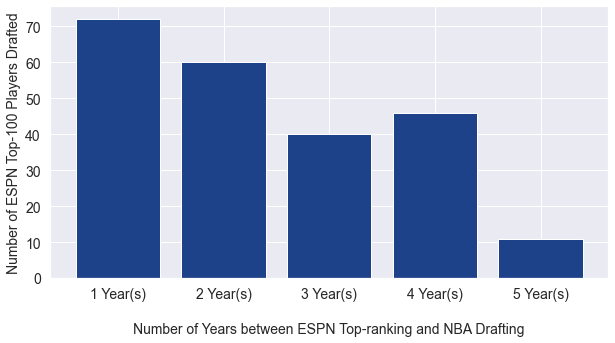

In [251]:
delta_yr = master_df[master_df['Drafted'] == 1]

delta_yr['Delta_Years'] = (abs(master_df['NBA_Drafting_Year'] - master_df['ESPN_Ranking_Year']))
#print(delta_yr.head())

delta_yr['Delta_Years'] = delta_yr['Delta_Years'].astype(int)
delta_yr['Delta_Years_Str'] = delta_yr['Delta_Years'].astype(str) + ' Year(s)'


plot_delta_yr = delta_yr[delta_yr['Drafted']==1].groupby('Delta_Years_Str', as_index=False)['Drafted'].count()
#plot_delta_yr['Grade'] = delta_yr[delta_yr['Drafted']==1].groupby('Delta_Years_Str', as_index=False)['Grade'].mean()
#plot_delta_yr['ESPN Rank'] = delta_yr[delta_yr['Drafted']==1].groupby('ESPN Rank', as_index=False)['ESPN Rank'].mean()
#plot_delta_yr['Height_inches'] = delta_yr[delta_yr['Drafted']==1].groupby('ESPN Rank', as_index=False)['ESPN Rank'].mean()

print(plot_delta_yr)


plt.figure(figsize = (10,5))
plt.bar(plot_delta_yr['Delta_Years_Str'], plot_delta_yr['Drafted'], align='center', color = '#1d428a')
plt.ylabel('Number of ESPN Top-100 Players Drafted', fontsize=14)
plt.xlabel('\nNumber of Years between ESPN Top-ranking and NBA Drafting', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()


#fig = plt.figure(figsize = (10,5))
#ax1 = fig.add_subplot(111)

#ax1.bar(plot_delta_yr['Delta_Years_Str'], plot_delta_yr['Drafted'], align='center', color = '#1d428a', label='Drafted ESPN Top-100 Players')
#ax1.plot(plot_delta_yr['Delta_Years_Str'], plot_delta_yr['Grade'], color = '#c8102e', label='Grades', linewidth=5)

#### Timeseries for number of ESPN Top-100 ranked players that are drafted by NBA

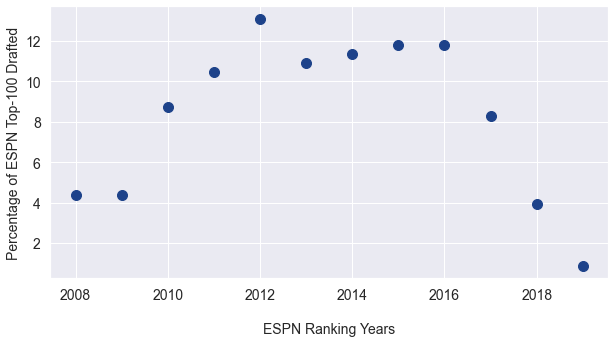

In [252]:
#master_df.head()
#perc_drafted = master_df[master_df['Drafted']==1].groupby(['NBA Drafting Year', 'ESPN Ranking Year'], as_index=False)['Drafted'].count()
perc_drafted = master_df[master_df['Drafted']==1].groupby(['NBA_Drafting_Year'], as_index=False)['Drafted'].count()
perc_drafted['Undrafted'] = 120 - perc_drafted['Drafted']
perc_drafted['NBA_Drafting_Year'] = perc_drafted['NBA_Drafting_Year'].astype(int)

perc_drafted

plt.figure(figsize = (10,5))
plt.scatter(perc_drafted['NBA_Drafting_Year'], perc_drafted['Drafted']/sum(perc_drafted['Drafted'])*100, s=100, color = '#1d428a')
plt.ylabel('Percentage of ESPN Top-100 Drafted', fontsize=14)
plt.xlabel('\nESPN Ranking Years', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### ESPN Average Grades for Top-100 Players: Drafted vs Non Drafted by NBA

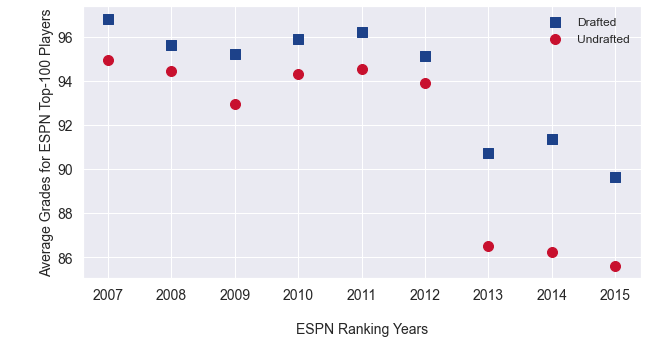

In [253]:
grade = master_df[master_df['Drafted']==1].groupby(['ESPN_Ranking_Year'], as_index=False)['Grade'].mean()
grade_undrafted = master_df[master_df['Drafted']==0].groupby(['ESPN_Ranking_Year'], as_index=False)['Grade'].mean()

#grade_undrafted.head()
#grade.head()

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)

ax1.scatter(grade['ESPN_Ranking_Year'], grade['Grade'], s=100, color = '#1d428a', marker="s", label='Drafted')
ax1.scatter(grade_undrafted['ESPN_Ranking_Year'],grade_undrafted['Grade'], s=100, color = '#c8102e', marker="o", label='Undrafted')
plt.ylabel('\n\nAverage Grades for ESPN Top-100 Players', fontsize=14)
plt.xlabel('\nESPN Ranking Years', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### ESPN Average Ranks for Top-100 Players: Drafted vs Non Drafted by NBA

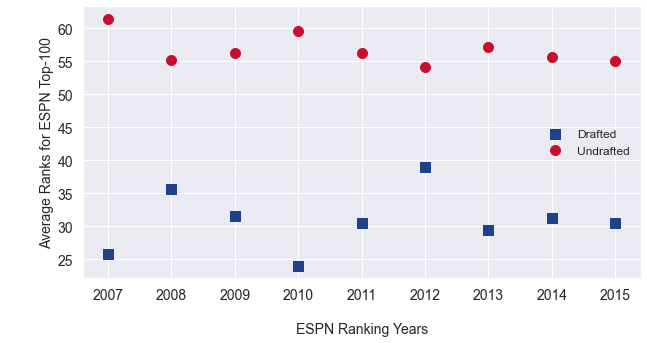

In [254]:
rank = master_df[master_df['Drafted']==1].groupby(['ESPN_Ranking_Year'], as_index=False)['ESPN Rank'].mean()
rank_undrafted = master_df[master_df['Drafted']==0].groupby(['ESPN_Ranking_Year'], as_index=False)['ESPN Rank'].mean()

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)

ax1.scatter(rank['ESPN_Ranking_Year'], rank['ESPN Rank'], s=100, color = '#1d428a', marker="s", label='Drafted')
ax1.scatter(rank_undrafted['ESPN_Ranking_Year'],rank_undrafted['ESPN Rank'], s=100, color = '#c8102e', marker="o", label='Undrafted')
plt.ylabel('\n\nAverage Ranks for ESPN Top-100', fontsize=14)
plt.xlabel('\nESPN Ranking Years', fontsize=14)
plt.legend(loc='center right', fontsize=12)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### Average Weight for ESPN Top-100 Players: Drafted vs Non Drafted by NBA

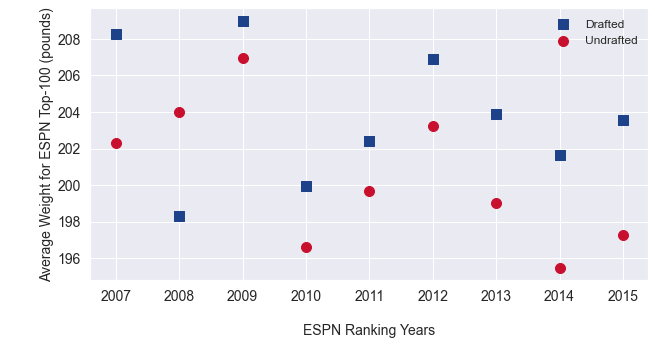

In [255]:
weight = master_df[master_df['Drafted']==1].groupby(['ESPN_Ranking_Year'], as_index=False)['Weight_pounds'].mean()
weight_undrafted = master_df[master_df['Drafted']==0].groupby(['ESPN_Ranking_Year'], as_index=False)['Weight_pounds'].mean()

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)

ax1.scatter(weight['ESPN_Ranking_Year'], weight['Weight_pounds'], s=100, color = '#1d428a', marker="s", label='Drafted')
ax1.scatter(weight_undrafted['ESPN_Ranking_Year'],weight_undrafted['Weight_pounds'], s=100, color = '#c8102e', marker="o", label='Undrafted')
plt.ylabel('\n\nAverage Weight for ESPN Top-100 (pounds)', fontsize=14)
plt.xlabel('\nESPN Ranking Years', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### Average Height for ESPN Top-100 Players: Drafted vs Non Drafted by NBA 

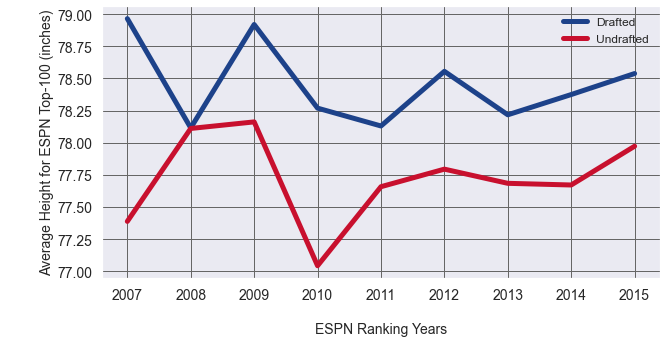

In [256]:
height = master_df[master_df['Drafted']==1].groupby(['ESPN_Ranking_Year'], as_index=False)['Height_inches'].mean()
height_undrafted = master_df[master_df['Drafted']==0].groupby(['ESPN_Ranking_Year'], as_index=False)['Height_inches'].mean()

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)

#ax1.scatter(height['ESPN Ranking Year'], height['height_inch'], s=20, c='b', marker="s", label='Drafted')
ax1.plot(height['ESPN_Ranking_Year'], height['Height_inches'], color = '#1d428a', label='Drafted', linewidth=5)
#ax1.scatter(height_undrafted['ESPN Ranking Year'],height_undrafted['height_inch'], s=20, c='r', marker="o", label='Undrafted')
ax1.plot(height_undrafted['ESPN_Ranking_Year'],height_undrafted['Height_inches'], color = '#c8102e',label='Undrafted', linewidth=5)
plt.ylabel('\n\nAverage Height for ESPN Top-100 (inches)', fontsize=14)
plt.xlabel('\nESPN Ranking Years', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## C.3 Choropleth of USA States Representation in ESPN Top-100 Ranking

In [108]:
choropleth_df = pd.merge(master_df.groupby('State', as_index=False)['Player'].count(), 
                         master_df[master_df['Drafted']>0].groupby('State', as_index=False)['Drafted'].count(), 
                         on='State', how='inner')

df = pd.read_html(requests.get('https://www.ssa.gov/international/coc-docs/states.html').content)[-1]
df.columns=['State','abbrv']

choropleth_df = pd.merge(choropleth_df, df, left_on="State", right_on='abbrv', how='outer')

choropleth_df['State_x'].fillna(choropleth_df['abbrv'], inplace=True)

choropleth_df['Player'].fillna(0, inplace=True)
choropleth_df['Player'] = choropleth_df['Player'].astype(int)

choropleth_df['Drafted'].fillna(0, inplace=True)
choropleth_df['Drafted'] = choropleth_df['Drafted'].astype(int)
#print(test_df.head())

for col in choropleth_df.columns:
    choropleth_df[col] = choropleth_df[col].astype(str)

choropleth_df['text'] = choropleth_df['State_y'] + '<br>' + \
                'ESPN Ranked: ' + choropleth_df['Player'] + '<br>' + \
                'NBA Drafted: ' + choropleth_df['Drafted']
#print(test_df.head())



#Canada = []
other_df = pd.DataFrame({'Region': ['USA', 'Canada', 'Overseas'], 
                         'Players': [0, 0, 0]})
#'Ontario, CAN, CAN, CAN' 'EUR' 'Quebec, CAN, CAN, CAN' 'DE' 'ME' 'SP'
# 'NE' 'UT' 'AUS' 'MT'
print(other_df)



fig = go.Figure(data=go.Choropleth(
    locations = choropleth_df['State_x'],
    z = choropleth_df['Player'], #/sum(test['Player']),
    locationmode = 'USA-states',
    colorscale = 'Blues', 
    #colorscale = 'Reds', 
    autocolorscale=False,
    text = choropleth_df['text'],
    marker_line_color='gray',
    colorbar_title = "raw numbers",
))

fig.update_layout(
    title_text = 'Number of High School Players in ESPN Top-100,<br>from 2007 to 2015',
    #geo_scope = 'usa'
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

     Region  Players
0       USA        0
1    Canada        0
2  Overseas        0


## C.4 SPLOM for Features Overview and Inter-Correlations

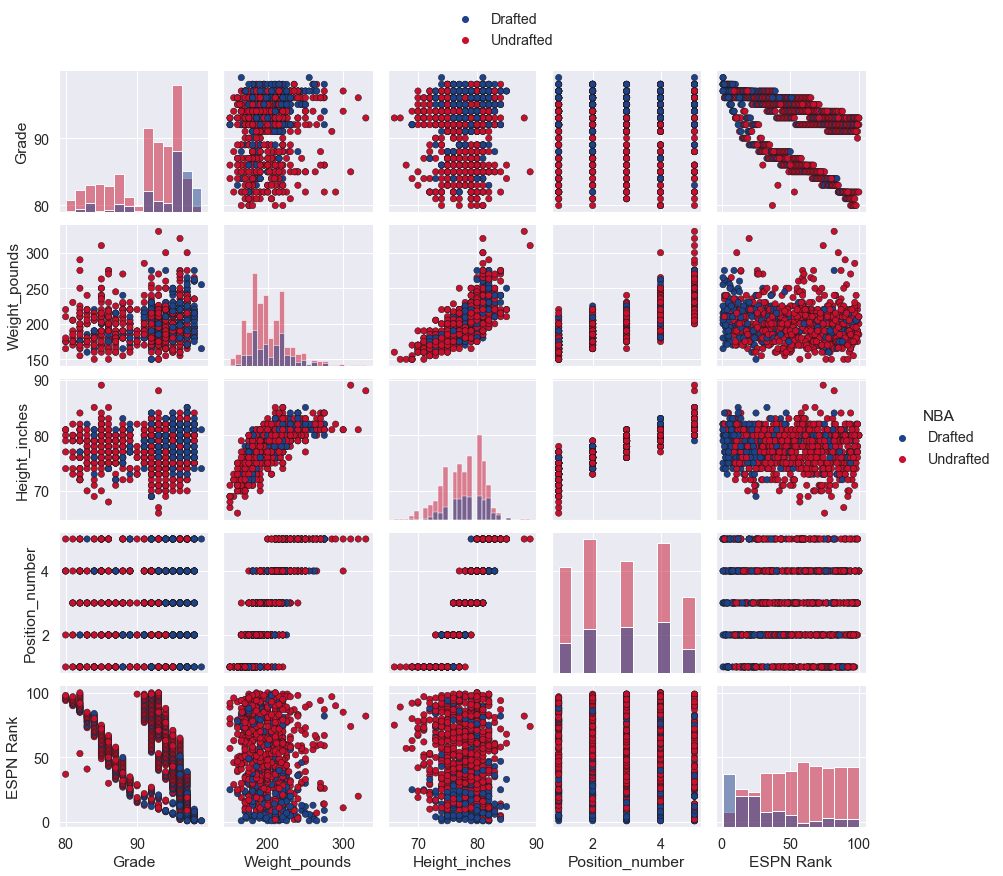

In [237]:
splom_df = master_df[['Grade', 'Weight_pounds', 'Height_inches', 'Position_number', 'ESPN Rank', 'Drafted']]

#splom_df['NBA'] = splom_df['filter']
splom_df.loc[splom_df['Drafted'] == 1, "NBA"] = "Drafted"
splom_df.loc[splom_df['Drafted'] == 0, "NBA"] = "Undrafted"
splom_df.drop('Drafted', axis=1, inplace=True)

#sns.pairplot(splom_df, hue='filter', palette=['#c8102e','#1d428a'], markers='d', size=2.5, plot_kws=
sns.set(font_scale=1.3)
g = sns.pairplot(splom_df, hue='NBA', palette=['#1d428a','#c8102e'], diag_kind='hist', size=2.5, plot_kws=
    {
    "s":40,
    "alpha":1.0,
    'lw':0.5,
    'edgecolor':'k'
    })
#g.ylabel(fontsize=14)
#g.xlabel(fontsize=14)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
#g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)
#g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

## C.5 Other Statistics

#### Exploratory Histogram

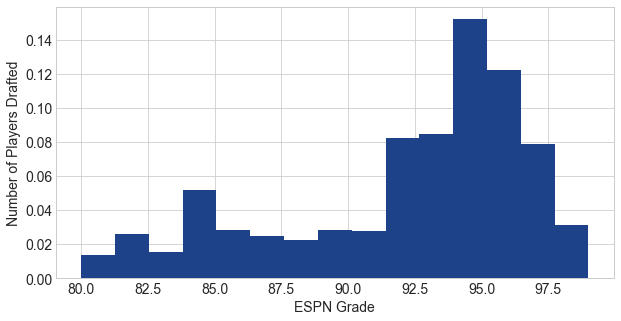

In [218]:
# Exploratory Histogram

np.random.seed(42)
#x = np.random.normal(size=1000)

plt.figure(figsize = (10,5))
plt.hist(master_df['Grade'], density=True, bins=15, facecolor = '#1d428a')  # density=False would make counts
plt.ylabel('Number of Players Drafted', fontsize=14)
plt.xlabel('ESPN Grade', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### Histogram to include in presentation?

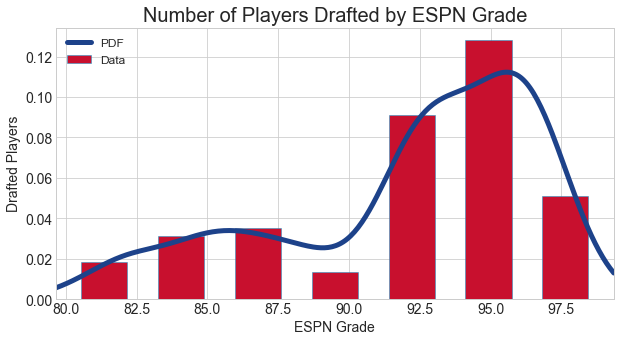

In [217]:
# Histogram to incldue in presendation
x = master_df['Grade']
plt.figure(figsize = (10,5))
plt.hist(x, density=True, bins=7, rwidth= .6,label="Data", facecolor = '#c8102e', edgecolor='#169acf',linewidth=.5)
plt.style.use('seaborn-whitegrid') 
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF", color = '#1d428a', linewidth=5)
plt.legend(loc="upper left", fontsize=12)
plt.ylabel('Drafted Players', fontsize=14)
plt.xlabel('ESPN Grade', fontsize=14)
plt.title("Number of Players Drafted by ESPN Grade",fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### Exploratory Histogram

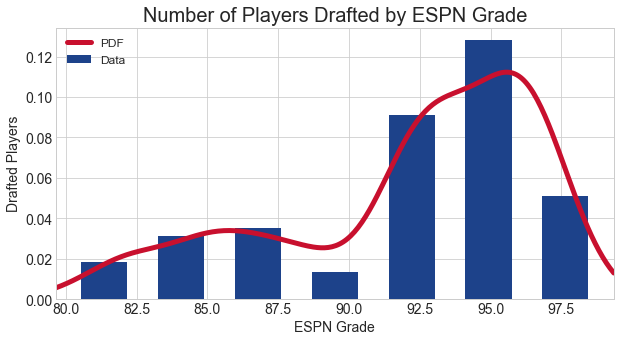

In [216]:
# Exploratory histogram 
plt.figure(figsize = (10,5))
y = espn_ranking['Grade']
plt.hist(y, density=True, bins=7, rwidth= .6, facecolor = '#1d428a', label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(y)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF", color = '#c8102e', linewidth=5)
plt.legend(loc="upper left", fontsize=12)
plt.ylabel('Drafted Players', fontsize=14)
plt.xlabel('ESPN Grade', fontsize=14)
plt.title("Number of Players Drafted by ESPN Grade", fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### Correlation between height and weight for ESPN Players: drafted vs non drafted

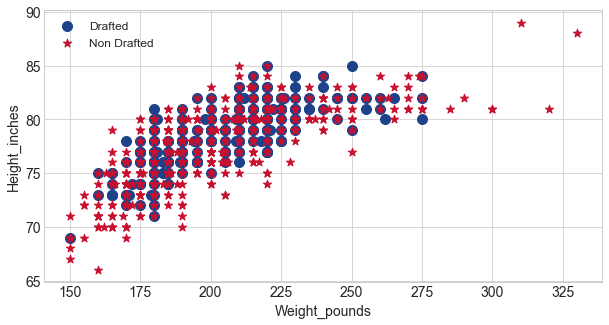

In [222]:
plt.figure(figsize=(10, 5))
plt.scatter(master_df[master_df['Drafted']==1]['Weight_pounds'], master_df[master_df['Drafted']==1]['Height_inches'], label='Drafted', c='#1d428a', s=100)
plt.scatter(master_df[master_df['Drafted']==0]['Weight_pounds'], master_df[master_df['Drafted']==0]['Height_inches'], label='Non Drafted', c='#c8102e', s=75, marker='*')

plt.legend(fontsize=12)
plt.xlabel('Weight_pounds', fontsize=14)
plt.ylabel('Height_inches', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# display
plt.show()

#### Correlation between rank and grade for ESPN Players: drafted vs non drafted

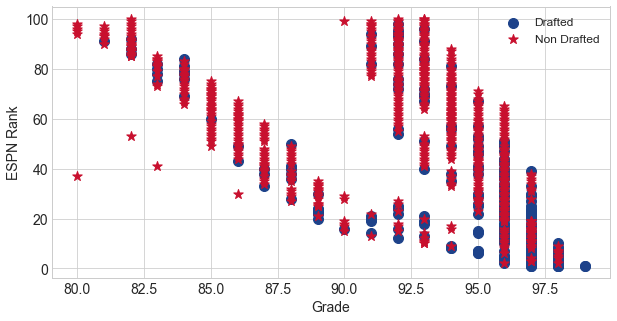

In [223]:
plt.figure(figsize=(10, 5))
plt.scatter(master_df[master_df['Drafted']==1]['Grade'], master_df[master_df['Drafted']==1]['ESPN Rank'], label='Drafted', s=100, c='#1d428a')
plt.scatter(master_df[master_df['Drafted']==0]['Grade'], master_df[master_df['Drafted']==0]['ESPN Rank'], label='Non Drafted', s=100, c='#c8102e', marker='*')

plt.legend(fontsize=12)
plt.xlabel('Grade', fontsize=14)
plt.ylabel('ESPN Rank', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# display
plt.show()

#### Correlation between position and grade for ESPN Players: drafted vs non drafted

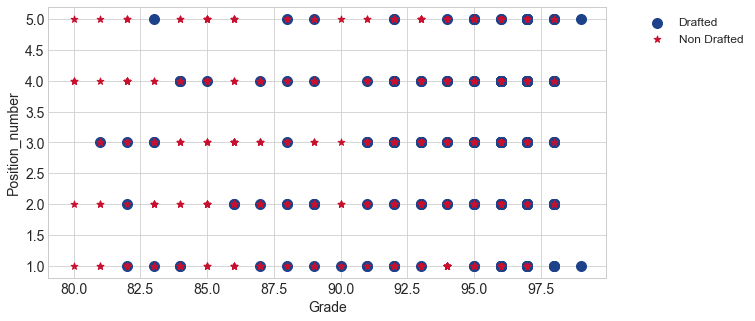

In [226]:
plt.figure(figsize=(10, 5))
plt.scatter(master_df[master_df['Drafted']==1]['Grade'], master_df[master_df['Drafted']==1]['Position_number'], label='Drafted', c='#1d428a', s=100)
plt.scatter(master_df[master_df['Drafted']==0]['Grade'], master_df[master_df['Drafted']==0]['Position_number'], label='Non Drafted', s=50, c='#c8102e', marker='*')

plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Grade', fontsize=14)
plt.ylabel('Position_number', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# display
plt.show()
#plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

# D. KNN Predictive Analysis

## D.1 Train Model

In [114]:
X = master_df[['Grade','Weight_pounds','Height_inches','Position_number', 'ESPN Rank' ]]
y = master_df['Drafted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#y_train.shape
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7918552036199095

## D.2 Classifiers and Effectiveness

In [115]:
# Look at effectiveness of various classifiers 
yas = []
neighbor = []
for i in range (1,21):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    yas.append(knn.score(X_test, y_test))
    neighbor.append(i)

# See what is the worst and best of classifiers 
yas
neighbor
def merge(yas, neighbor):
      
    merged_list = tuple(zip(yas, neighbor)) 
    return  min(merged_list),  max(merged_list)
      
# Driver code
list1 = [1, 2, 3]
list2 = ['a', 'b', 'c']
print(merge(yas, neighbor))

((0.7285067873303167, 1), (0.7918552036199095, 13))


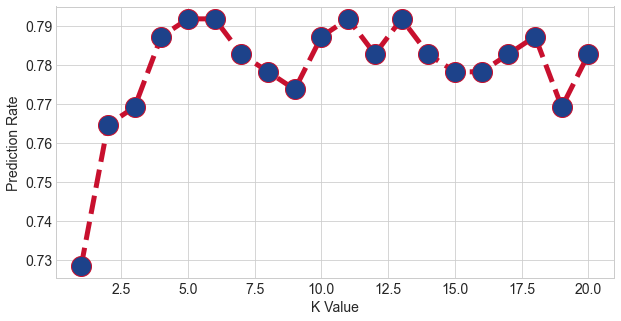

In [206]:
#Plot the different classfiers to see effectiveness 
plt.figure(figsize=(10, 5))
plt.plot(range(1,21), yas, color='#c8102e', linestyle='dashed', marker='o', linewidth=5,
         markerfacecolor='#1d428a', markersize=20)

#plt.title('Prediction Rate', fontsize=20)
plt.xlabel('K Value', fontsize=14)
#plt.ylabel('Prediction Percentage', fontsize=14)
plt.ylabel('Prediction Rate', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## D.3 Decision Boundaries [difficulties plotting the decision boundaries even with two attributes]

In [137]:
X = master_df[['Weight_pounds','Height_inches']]
y = master_df['Drafted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

a = np.arange(start=X_train['Weight_pounds'].min()-1, stop=X_train['Weight_pounds'].max()+1, step=0.5)
b = np.arange(start=X_train['Height_inches'].min()-1, stop=X_train['Height_inches'].max()+1, step=0.5)

XX, YY = np.meshgrid(a,b)

In [138]:
input_array = np.array([XX.ravel(),YY.ravel()]).T

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

labels = knn.predict(input_array)

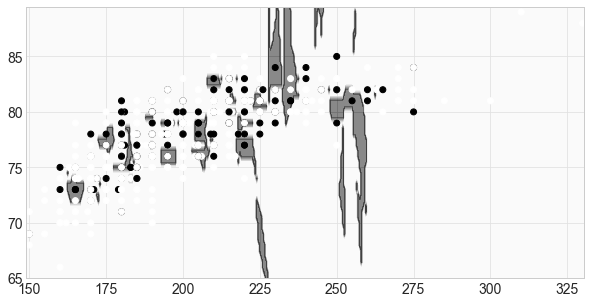

In [188]:
plt.figure(figsize=(10, 5))
plt.contourf(XX, YY, labels.reshape(XX.shape), alpha=0.5)
plt.scatter(X_train['Weight_pounds'], X_train['Height_inches'], c=y_train)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## D.4 Pivot Table (Further investigations)

In [225]:
#look at data by bins
master_df['bin'] = pd.cut(master_df['Grade'], [0,80,90,100])

#Add total to pivot with for bins 
pvtdf = master_df.pivot_table(index='Position', columns=['bin'], values='ESPN Rank', 
                       aggfunc=('count', 'count')).fillna(0)



pvtdf

count                                              
bin      (0, 80] (80, 90] (90, 100] (0, 80] (80, 90] (90, 100]
Position                                                      
C              1       27        89       1       27        89
PF             3       50       160       3       50       160
PG             1       52       106       1       52       106
SF             0       47       139       0       47       139
SG             1       54       154       1       54       154